In [58]:
import os
import json

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils.exploratory import zip_dtype

from sklearn.linear_model import LinearRegression

In [2]:
plt.rcParams['figure.figsize'] = [24, 18]

In [3]:
def filter_ideb(ideb):
    cols_type_str = ['Co_UF', 'Nome_Municipio', 'Nome_Escola', 'Rede']
    for col in ideb:
        if col in cols_type_str:
            ideb[col] = ideb[col].astype('str')
        else:
            ideb[col] = ideb[col].astype(str).str.replace(',', '.').str.replace('*', '').str.replace('ND','NaN').astype(np.float64)
    return

In [4]:
def is_constant(x):
   try:
       x = x.values
   except AttributeError:
       pass

   return (x == x[0]).all()

## Carregando os dados do IDEB

In [5]:
ideb_iniciais = pd.read_csv('../data/ideb/ideb_escolas_anosiniciais2005_2017.csv', encoding='latin1', na_values=['-', 'ND','ND**'])
filter_ideb(ideb_iniciais)
ideb_iniciais['Cod_Municipio_Completo'] = ideb_iniciais['Cod_Municipio_Completo'].astype(np.float64)

ideb_finais = pd.read_csv('../data/ideb/ideb_escolas_anosfinais2005_2017.csv', encoding='latin1', na_values=['-', 'ND','ND**'])
filter_ideb(ideb_finais)
ideb_finais['Cod_Municipio_Completo'] = ideb_finais['Cod_Municipio_Completo'].astype(np.float64)

/home/joao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (64,65,67,68,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/joao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (60,61,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Carregando os dados das escolas

In [110]:
def merge_ideb_to_frame(year, frame, ideb_iniciais, ideb_finais):
    cols = ideb_iniciais.columns[ideb_iniciais.columns.str.match(r'Cod_Escola_Completo|'+'Ideb'+str(year))]
    ideb_iniciais_ano = ideb_iniciais[cols]
    cols = ideb_finais.columns[ideb_finais.columns.str.match(r'Cod_Escola_Completo|'+'Ideb'+str(year))]
    ideb_finais_ano = ideb_finais[cols]

    frame_merge = frame.merge(ideb_iniciais_ano, left_on='cod_escola_inep', right_on='Cod_Escola_Completo', how='left', suffixes=['',''])
    frame_merge = frame_merge.merge(ideb_finais_ano, left_on='cod_escola_inep', right_on='Cod_Escola_Completo', how='left', suffixes=['','_final'])

    return frame_merge

def load_escolas(year):
    escolas = pd.read_csv('../data/escolas/escolas' + str(year) + '0101.csv',
                               dtype=zip_dtype('../schemas/escolas_schema.json'))
    escolas['cod_escola_inep'] = escolas['cod_escola_inep'].astype(np.float64)
    constant_columns = escolas.apply(lambda x: is_constant(x))
    escolas = escolas.drop(constant_columns[constant_columns==True].index, axis=1)
    escolas = escolas[escolas['tp_rede'].str.lower() != 'privada']
    escolas = escolas[escolas['tp_rede_publica'] == True]
    
    return escolas

def clean_escola(escolas):
    to_remove = []
    to_int = []    
    for col in escolas.columns:
        col_type = escolas[col].dtype

        if col_type == 'object':
            to_remove.append(col)
        elif col_type == 'bool':
            to_int.append(col)

    escolas = escolas.drop(to_remove,axis=1)
    escolas[to_int] = escolas[to_int].astype(np.float64)
    
    return escolas

In [111]:
escolas_2017 = load_escolas(2017) #, ideb_iniciais, ideb_finais)
escolas_2015 = load_escolas(2015) #, ideb_iniciais, ideb_finais)

/home/joao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (10,12,52,59,61,63,64,68,69,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,98,99,102,104,105,107,108,113,121,124,125,126,127,128,129,130,136,152,155,191) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [112]:
escolas_2017[escolas_2017['tp_rede'].str.lower() != 'privada'][escolas_2017['tp_rede_publica'] == True]['tp_rede'].value_counts()

Municipal    113642
Estadual      30848
Federal         700
Name: tp_rede, dtype: int64

In [113]:
escolas_2017.columns.tolist()

['Unnamed: 0',
 'cod_escola_inep',
 'regiao',
 'unidade_federativa',
 'mesoregiao',
 'microregiao',
 'municipio',
 'tp_dependencia',
 'tp_dependencia_desc',
 'tp_rede_publica',
 'rede_publica_desc',
 'in_somente_matriculas_ac_ou_aee',
 'tp_rede',
 'tp_rede_nome',
 'tp_rede_cod',
 'nome_escola',
 'num_matriculas',
 'num_estudantes',
 'in_comum_creche',
 'in_comum_pre',
 'in_comum_fund_ai',
 'in_comum_fund_af',
 'in_comum_medio_medio',
 'in_comum_medio_integrado',
 'in_comum_medio_normal',
 'num_estudantes_ensino_infantil',
 'num_estudantes_ensino_fund_anos_iniciais',
 'num_estudantes_ensino_fund_anos_finais',
 'num_estudantes_ensino_medio_propedeutico',
 'num_estudantes_fund_1_ano',
 'num_estudantes_fund_2_ano',
 'num_estudantes_fund_3_ano',
 'num_estudantes_fund_4_ano',
 'num_estudantes_fund_5_ano',
 'num_estudantes_fund_6_ano',
 'num_estudantes_fund_7_ano',
 'num_estudantes_fund_8_ano',
 'num_estudantes_fund_9_ano',
 'num_estudantes_medio_1_serie',
 'num_estudantes_medio_2_serie',
 'n

In [114]:
escolas_2017 = clean_escola(escolas_2017)
escolas_2015 = clean_escola(escolas_2015)
escolas_2017.columns.tolist()

['Unnamed: 0',
 'cod_escola_inep',
 'num_matriculas',
 'num_estudantes',
 'in_comum_creche',
 'in_comum_pre',
 'in_comum_fund_ai',
 'in_comum_fund_af',
 'in_comum_medio_medio',
 'in_comum_medio_integrado',
 'in_comum_medio_normal',
 'num_estudantes_ensino_infantil',
 'num_estudantes_ensino_fund_anos_iniciais',
 'num_estudantes_ensino_fund_anos_finais',
 'num_estudantes_ensino_medio_propedeutico',
 'num_estudantes_fund_1_ano',
 'num_estudantes_fund_2_ano',
 'num_estudantes_fund_3_ano',
 'num_estudantes_fund_4_ano',
 'num_estudantes_fund_5_ano',
 'num_estudantes_fund_6_ano',
 'num_estudantes_fund_7_ano',
 'num_estudantes_fund_8_ano',
 'num_estudantes_fund_9_ano',
 'num_estudantes_medio_1_serie',
 'num_estudantes_medio_2_serie',
 'num_estudantes_medio_3_serie',
 'num_estudantes_medio_4_serie',
 'num_estudantes_medio_nao_seriada',
 'num_turmas',
 'in_em_atividade',
 'in_local_func_predio_escolar',
 'in_local_func_socioeducativo',
 'in_local_func_prisional_socio',
 'in_local_func_galpao',
 

In [115]:
dataframe = escolas_2017

select_columns_raw = [column for column in dataframe.columns if not (
    column.startswith('ideb_')
    or column.startswith('Taxa')
    or column.startswith('Nota')
    or column.startswith('Projecao')
    or column.startswith('etapa')
    or column.startswith('in_equip')
    or column.startswith('in_agua')
    or column.startswith('in_energia')
    or column.startswith('in_local')
    or column.startswith('Indicador')
    or column.startswith('Unnamed')
    or column.endswith('_y')
    or column.endswith('_desc')
)]

drop_columns = [
                #'num_matriculas',
                #'num_estudantes',
               ]

final_cols = (set(select_columns_raw) - set(drop_columns))
len(final_cols)

82

In [116]:
escolas_2017_clean = escolas_2017[select_columns_raw]
escolas_2017_clean = escolas_2017_clean.drop(drop_columns, axis=1)
escolas_2015_clean = escolas_2015[select_columns_raw]
escolas_2015_clean = escolas_2015_clean.drop(drop_columns, axis=1)

In [117]:
_suffix = '_diff'
diff_1715 = escolas_2017_clean.merge(escolas_2015_clean, on='cod_escola_inep', how='inner', suffixes=['',_suffix])

for col in diff_1715.columns:
    if col == 'cod_escola_inep':
        continue
    elif col.endswith(_suffix):
        continue
    else:
        diff_1715[col + _suffix] = diff_1715[col] - diff_1715[col + _suffix]

In [118]:
to_drop = ['Cod_Escola_Completo', 'Cod_Escola_Completo_final']
diff_1715 = merge_ideb_to_frame(2017, diff_1715, ideb_iniciais, ideb_finais).drop(to_drop, axis=1)
diff_1715 = merge_ideb_to_frame(2015, diff_1715, ideb_iniciais, ideb_finais).drop(to_drop, axis=1)
diff_1715.head()

cod_escola_inep  num_matriculas  num_estudantes  in_comum_creche  \
0       11048395.0            83.0            83.0              1.0   
1       11043040.0            30.0            30.0              0.0   
2       11040351.0            16.0            16.0              0.0   
3       11106824.0             6.0             6.0              0.0   
4       11094834.0            76.0            76.0              0.0   

   in_comum_pre  in_comum_fund_ai  in_comum_fund_af  in_comum_medio_medio  \
0           0.0               0.0               0.0                   0.0   
1           1.0               0.0               0.0                   0.0   
2           1.0               0.0               0.0                   0.0   
3           0.0               0.0               1.0                   1.0   
4           0.0               0.0               0.0                   0.0   

   in_comum_medio_integrado  in_comum_medio_normal       ...        \
0                       0.0                    0.0       ...         
1                       0.0                    0.0       ...         
2                       0.0                    0.0       ...         
3                       0.0                    0.0       ...         
4                       0.0                    0.0       ...         

   in_brasil_alfabetizado_diff  in_final_semana_diff  \
0                          0.0                   0.0   
1                          0.0                   0.0   
2                          0.0                   0.0   
3                          0.0                   0.0   
4                          0.0                   0.0   

   in_formacao_alternancia_diff  num_matriculas_ensino_integral_diff  \
0                           0.0                                 -2.0   
1                           0.0                                  NaN   
2                           0.0                                  NaN   
3                           0.0                                  NaN   
4                           0.0                                  NaN   

   num_estudantes_ensino_integral_diff  tp_integral_diff  Ideb2017  \
0                                 -2.0               0.0       NaN   
1                                  NaN               0.0       NaN   
2                                  NaN               0.0       NaN   
3                                  NaN               0.0       NaN   
4                                  NaN               0.0       NaN   

   Ideb2017_final  Ideb2015  Ideb2015_final  
0             NaN       NaN             NaN  
1             NaN       NaN             NaN  
2             NaN       NaN             NaN  
3             NaN       NaN             NaN  
4             NaN       NaN             NaN  

[5 rows x 167 columns]

In [119]:
diff_1715.columns.tolist()

['cod_escola_inep',
 'num_matriculas',
 'num_estudantes',
 'in_comum_creche',
 'in_comum_pre',
 'in_comum_fund_ai',
 'in_comum_fund_af',
 'in_comum_medio_medio',
 'in_comum_medio_integrado',
 'in_comum_medio_normal',
 'num_estudantes_ensino_infantil',
 'num_estudantes_ensino_fund_anos_iniciais',
 'num_estudantes_ensino_fund_anos_finais',
 'num_estudantes_ensino_medio_propedeutico',
 'num_estudantes_fund_1_ano',
 'num_estudantes_fund_2_ano',
 'num_estudantes_fund_3_ano',
 'num_estudantes_fund_4_ano',
 'num_estudantes_fund_5_ano',
 'num_estudantes_fund_6_ano',
 'num_estudantes_fund_7_ano',
 'num_estudantes_fund_8_ano',
 'num_estudantes_fund_9_ano',
 'num_estudantes_medio_1_serie',
 'num_estudantes_medio_2_serie',
 'num_estudantes_medio_3_serie',
 'num_estudantes_medio_4_serie',
 'num_estudantes_medio_nao_seriada',
 'num_turmas',
 'in_em_atividade',
 'in_quadra_esportes_coberta',
 'in_quadra_esportes_descoberta',
 'in_quadra_esportes',
 'in_sala_leitura',
 'in_biblioteca_sala_leitura',
 '

In [120]:
diff_1715['Ideb'] = diff_1715['Ideb2017'] - diff_1715['Ideb2015']
diff_1715['Ideb_final'] = diff_1715['Ideb2017_final'] - diff_1715['Ideb2015_final']

In [121]:
to_drop = [
    'cod_escola_inep',
    'Ideb2017',
    'Ideb2017_final',
    'Ideb2015',
    'Ideb2015_final',
    'Ideb',
    'Ideb_final',
]

diff_1715_clean = diff_1715.dropna(subset=['Ideb'])
y = diff_1715_clean.reset_index()['Ideb']
#y_final = diff_1715.reset_index()['Ideb_final']

diff_1715_clean = diff_1715_clean.drop(to_drop, axis=1)
diff_1715_clean = diff_1715_clean.fillna(diff_1715_clean.mean())

In [122]:
reg = LinearRegression().fit(diff_1715_clean, y, )

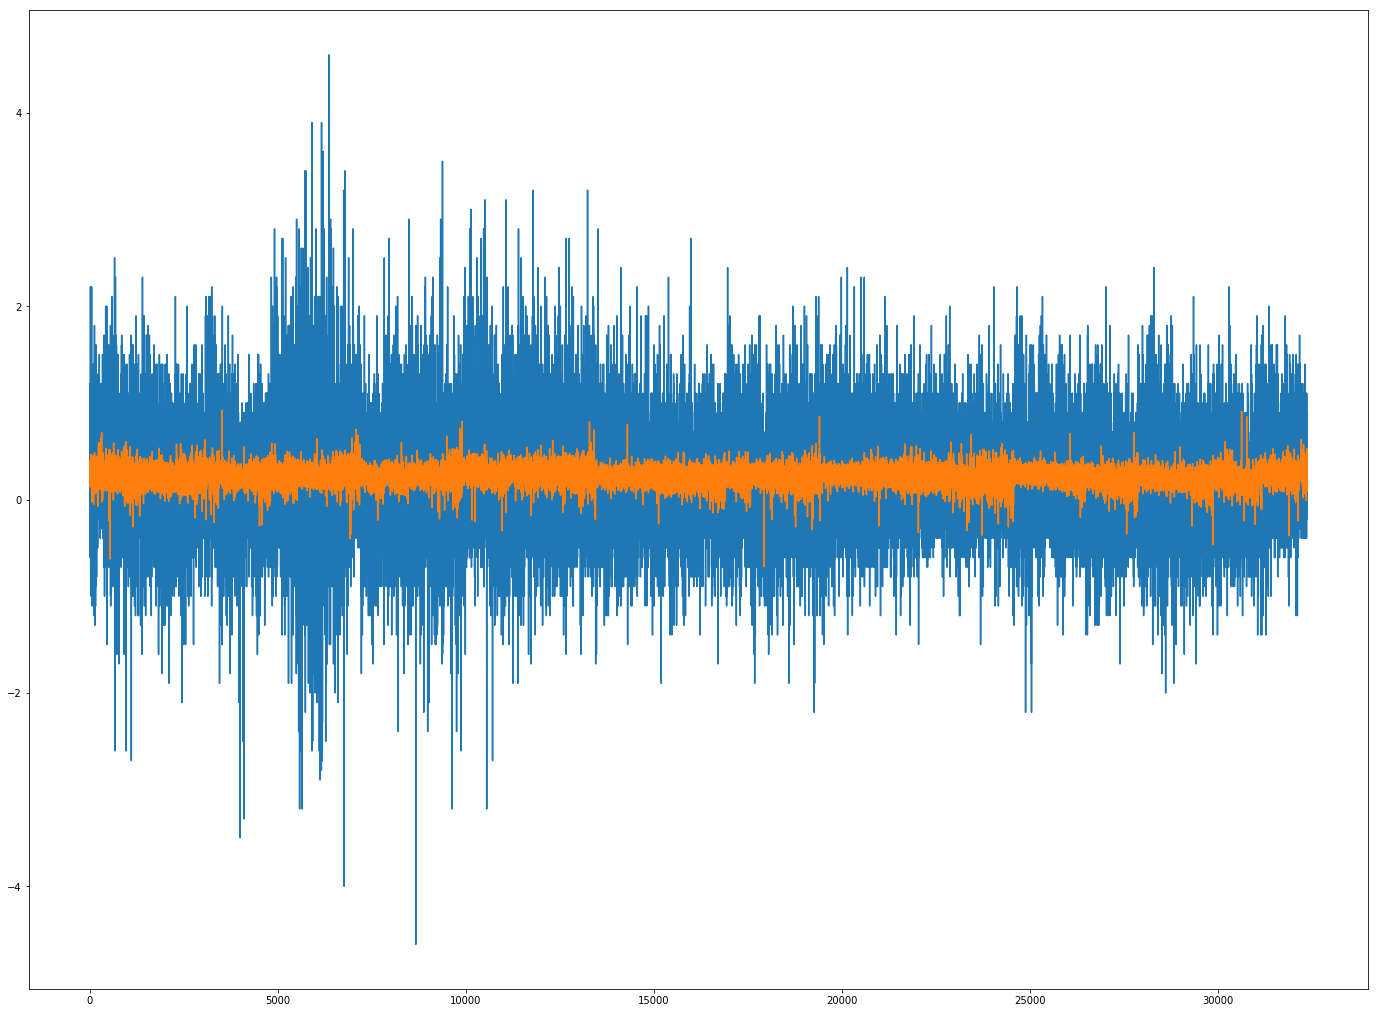

In [123]:
pred_ideb = reg.predict(diff_1715_clean)
plt.plot(y)
plt.plot(pred_ideb)
#(diff_1715_clean.values == np.inf).any()

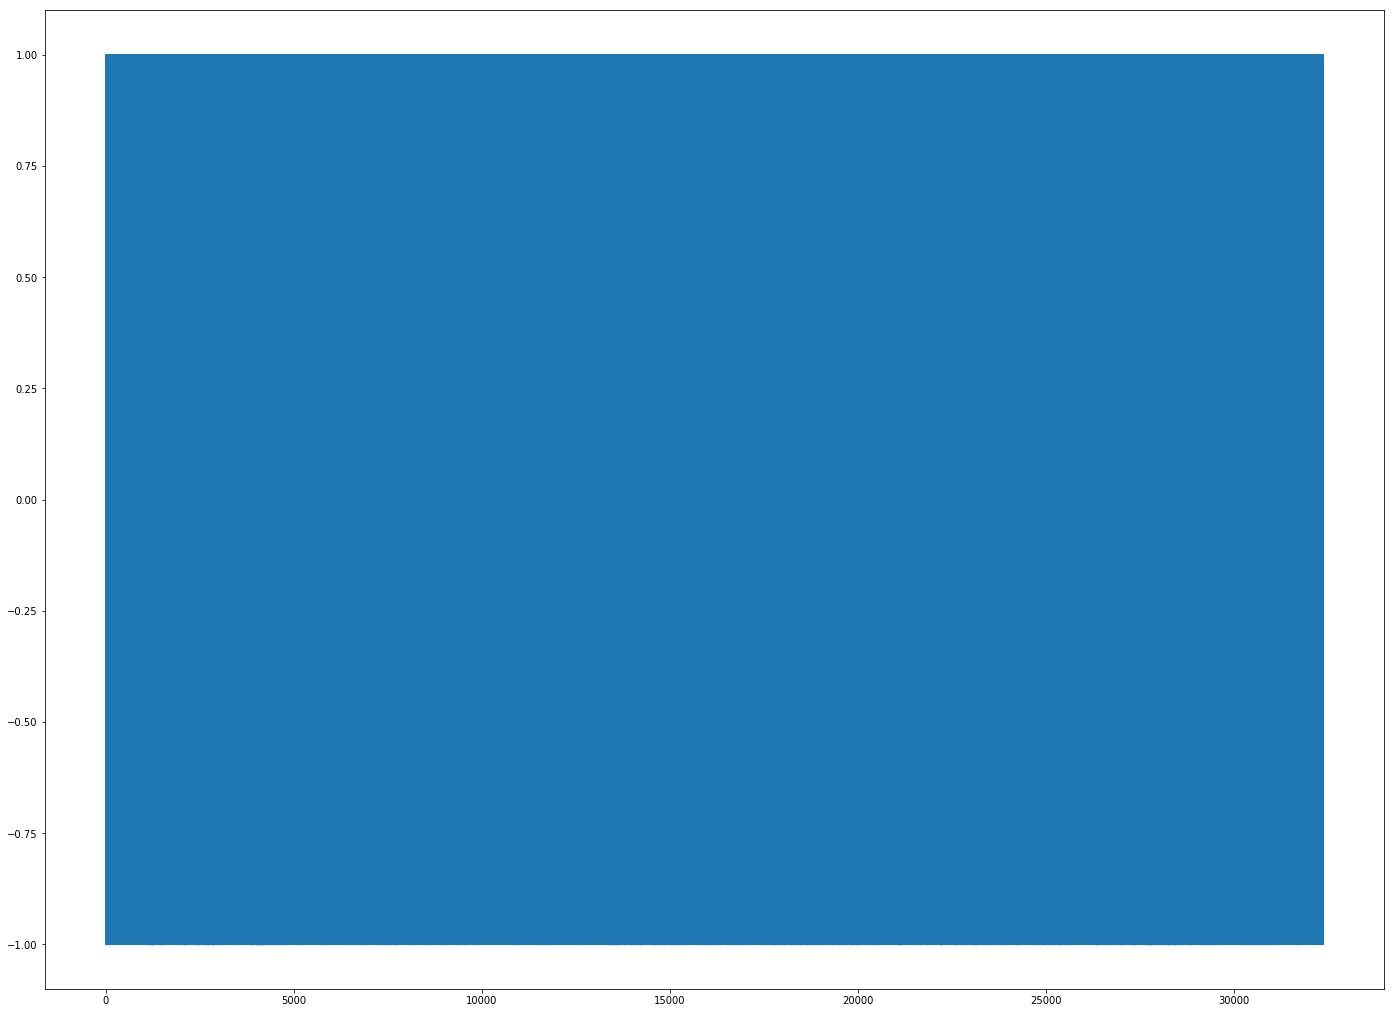

In [124]:
sig= y*pred_ideb
plt.plot(sig/np.abs(sig))

In [125]:
(sig/np.abs(sig)).value_counts()

 1.0    20632
-1.0     9462
Name: Ideb, dtype: int64

In [126]:
(y/np.abs(y)).value_counts()

 1.0    20665
-1.0     9429
Name: Ideb, dtype: int64

In [127]:
(pred_ideb/np.abs(pred_ideb)).sum()

31658.0